In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
import os
import sys
sys.path.append('..')

from familiarity.commons import get_layers_of_interest
from familiarity.familiarization import get_results 
from familiarity.config import DATA_DIR

figs_dir='../figures'
data_dir=os.path.join(DATA_DIR, 'fine_tuning')

def get_all_results(net, dataset, training_sets, results_type='verification-dprime', **kwargs):
    results = dict(layer=[], training_set=[], familiar=[])
    familiar_epoch = -1
    if 'dprime' in results_type:
        results['dprime']= []
    elif 'AUC' in results_type:
        results['AUC'] = []
    elif 'rates' in results_type:
        results['fpr'], results['tpr'] = [], []
    for training_set, net_name in training_sets.items():
        for layer in layers:
            for epoch in [0,familiar_epoch]:
                use_epoch = epoch if layer in ['IT', 'decoder', 'class-prob', 'fc6', 'fc7', 'prob'] else 0
                try:
                    res = get_results(results_type, net_name, dataset, use_epoch, layer, **kwargs)
                    results['layer'].append(layer)
                    results['familiar'].append(epoch == familiar_epoch)
                    results['training_set'].append(training_set)
                    if 'dprime' in results_type:
                        results['dprime'].append(res)
                    elif 'AUC' in results_type:
                        results['AUC'].append(res)
                    elif 'rates' in results_type:
                        results['fpr'].append(res[0])
                        results['tpr'].append(res[1])
                except Exception as e: 
                    print(e)
                    ipdb.set_trace()
                    pass
    results = pd.DataFrame(results)
    return results

def plot_separate(results, base_fn=None, hue='training_set', condition=1):
    kwargs={'palette':'bright', 'height':4}
    g = sns.catplot('layer', 'dprime', hue=hue, col='familiar', split=True, kind='point', ci=95,
              data=results[np.logical_and(condition,np.ones((len(results),)))], ylabel=r"verification $d$'", **kwargs)
    g.set_xticklabels(rotation=45)
    g.set_ylabel(r"verification $d'$")
    if base_fn is not None:
        plt.savefig(f'{figs_dir}/verification/{base_fn}.png', bbox_inches='tight')
    plt.show()
    
def plot_together(results, base_fn=None, 
                  familiar=None, 
                  hue='training_set', 
                  condition=1,
                  title=None,
                  figsize=None,
                 ):
    fig, ax = plt.subplots(figsize=figsize)
    fam_tag = '_familiar' if familiar is 'familiar' else '_unfamiliar' if familiar is 'unfamiliar' else ''
    if familiar is not 'unfamiliar':
        sns.pointplot('layer', 'dprime', hue=hue, ax=ax, palette='bright', ci=95,
                      data=results[np.logical_and(condition,results.familiar==True)])
    if familiar is not 'familiar':
        sns.pointplot('layer', 'dprime', hue=hue, ax=ax, linestyles='--', markers='v', palette='colorblind',ci=95,
                      data=results[np.logical_and(condition,results.familiar==False)])
    handles, labels = ax.get_legend_handles_labels() 
    if familiar is None:
        nn = len(np.unique(getattr(results, hue)))
        labels = [label + '-familiar' if ii<nn else label+'-unfamiliar' for ii, label in enumerate(labels)]
        leg_title = 'training set, familiarized'
    else:
        leg_title = 'training set'
    l = plt.legend(handles, labels, bbox_to_anchor=(.1, 1), title=leg_title,loc=2, borderaxespad=0.)
    plt.xticks(rotation=45)
    plt.ylim(-0.2,4.7)
    plt.ylabel("verification d'")
#     plt.ylabel(r"verification $d$'")
    if title is not None:
        plt.title(title)
    if base_fn is not None:
        fig.savefig(f'{figs_dir}/verification/{base_fn}{fam_tag}.png', bbox_inches='tight')
    plt.show()

def get_dset_kwargs(dataset):
    kwargs = {}
    kwargs['no_presoftmax_recorded'] = True
    if dataset == 'lfw-deepfunneled':
        kwargs['id_thresh'] = 18
        kwargs['n_val'] = 10
        kwargs['max_ids'] = None
        kwargs['first_finetuned_layer'] = 'fc6'
    elif dataset == 'vggface2-test':
        kwargs['id_thresh'] = 20
        kwargs['n_val'] = 19
        kwargs['max_ids'] = 100
    else:
        kwargs['id_thresh'] = 20
        kwargs['n_val'] = 19
        kwargs['max_ids'] = None 
    return kwargs

In [2]:
net='vgg16'
dataset='lfw-deepfunneled'
kwargs = get_dset_kwargs(dataset)
kwargs['data_dir'] = data_dir
_, layers = get_layers_of_interest(net)
layers.remove('fc8') # we ran these analyses without saving fc8

In [3]:
training_sets = dict(faces=f'{net}_train-vggface2-match-imagenet-subset',
                    objects=f'{net}_train-imagenet-subset', 
                    nothing=f'{net}_random')
results = get_all_results(net, dataset, training_sets, **kwargs)

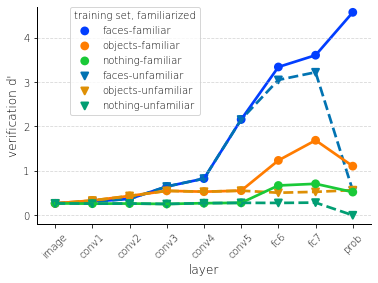

In [4]:
base_fn = f'{net}_verify-{dataset}_all-layer-plot'
plot_together(results, base_fn)